In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

In [2]:
from datautils import *
# from sphUtils import *
from lossFunctions import *

In [3]:
training, validation, counter = getSamples(1024, maxRollOut = 8, chunked = True, trainValidationSplit = 0.8, limitRollOut = False)

In [4]:

# trainingSample = training[np.random.permutation(np.arange(training.shape[0]))]
trainingSample = training
trainingCounter = counter[trainingSample]
validationSample = copy.copy(validation)
validationCounter = counter[validationSample]
# print(trainingSample, trainingCounter)
# print(validationSample, validationCounter)

In [5]:
# fig, axis = plt.subplots(1,1, figsize=(9,3), sharex = True, sharey = False, squeeze = False)

# axis[0,0].imshow(counter[None,:], aspect='auto', interpolation='nearest')

In [6]:
# basePath = '~/servus03/dev/rbfConvolution/output_smaller_arch'
basePath = '../export'
# basePath = '~/servus03/dev/rbfConvolution/outputs/output_smaller_arch'
basePath = os.path.expanduser(basePath)

In [7]:
simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
for i, c in enumerate(simulationFiles):
    print(i ,c)

0 ../export/dambreak - 2023-02-09_13-21-08.hdf5
1 ../export/dambreak - 2023-02-09_09-54-16.hdf5


In [8]:
simulationFiles = [simulationFiles[0]]

In [8]:
inFile = h5py.File(simulationFiles[0], 'r')
frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
inFile.close()

In [9]:
debugPrint(frameCount)

frameCount [int] = 1999


In [10]:
# def splitFile(s, skip = 32, cutoff = 300, chunked = True, maxRollOut = 8, split = True, trainValidationSplit = 0.8, testSplit = 0.1, limitRollOut = False):
#     inFile = h5py.File(s, 'r')
#     frameCount = int(len(inFile.keys()) -1) # adjust for bptcls
#     inFile.close()
    
#     frameCount = min(cutoff, frameCount)
#     actualCount = frameCount - 1 - skip
    
#     if not split:
#         training, _, counter = getSamples(actualCount, maxRollOut = maxRollOut, chunked = chunked, trainValidationSplit = 1.)
#         return s, training + skip, counter
    
#     testIndex = frameCount - 1 - int(actualCount * testSplit)
#     testSamples = frameCount - 1 - testIndex
    
#     testingIndices, _, testingCounter = getSamples(testSamples, maxRollOut = maxRollOut, chunked = chunked, trainValidationSplit = 1.)
#     testingIndices = testingIndices + testIndex
    
#     trainingIndices, validationIndices, trainValidationCounter = getSamples(testIndex - skip, maxRollOut = maxRollOut, chunked = chunked, trainValidationSplit = trainValidationSplit, limitRollOut = limitRollOut)
#     trainingCounter = trainValidationCounter[trainingIndices]
#     validationCounter = -trainValidationCounter[validationIndices]
    
#     trainingIndices = trainingIndices + skip
#     validationIndices = validationIndices + skip
    
    
#     return s, (trainingIndices, trainingCounter), (validationIndices, validationCounter), (testingIndices, testingCounter)
    
    
training = []
validation = []
testing = []


for s in simulationFiles:    
    _, train, valid, test = splitFile(s, split = True, limitRollOut = False, skip = 0, cutoff = 1600)
    training.append((s,train))
    validation.append((s,valid))
    testing.append((s,test))

In [11]:
debugPrint(training)

training [list] = [('../export/dambreak - 2023-02-09_13-21-08.hdf5', (array([   0,    1,    2, ..., 1437, 1438, 1439]), array([8, 8, 7, ..., 3, 2, 1], dtype=int32))), ('../export/dambreak - 2023-02-09_09-54-16.hdf5', (array([   0,    1,    2, ..., 1437, 1438, 1439]), array([8, 8, 8, ..., 3, 2, 1], dtype=int32)))]


In [12]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader


class datasetLoader(Dataset):
    def __init__(self, data):
        self.frameCounts = [indices[0].shape[0] for s, indices in data]
        self.fileNames = [s for s, indices in data]
        
        self.indices = [indices[0] for s, indices in data]
        self.counters = [indices[1] for s, indices in data]
        
#         print(frameCounts)
        
        
    def __len__(self):
#         print('len', np.sum(self.frameCounts))
        return np.sum(self.frameCounts)
    
    def __getitem__(self, idx):
#         print(idx , ' / ', np.sum(self.frameCounts))
        cs = np.cumsum(self.frameCounts)
        p = 0
        for i in range(cs.shape[0]):
#             print(p, idx, cs[i])
            if idx < cs[i] and idx >= p:
#                 print('Found index ', idx, 'in dataset ', i)
#                 print('Loading frame ', self.indices[i][idx - p], ' from dataset ', i, ' for ', idx, p)
                return self.fileNames[i], self.indices[i][idx - p], self.counters[i][idx-p]
        

                return (i, self.indices[i][idx - p]), (i, self.indices[i][idx-p])
#                 return torch.rand(10,1), 2
            p = cs[i]
        return None, None


In [17]:
simFile = simulationFiles[0]
inFile = h5py.File(simFile)

In [18]:
grp = inFile['simulationExport']['%05d' % 1]
debugPrint(inFile.keys())

inFile.keys() [KeysViewHDF5] = <KeysViewHDF5 ['boundaryInformation', 'simulationExport']>


In [19]:

inFile = h5py.File(simulationFiles[0])
inGrp = inFile['simulationExport']['%05d' % 0]

In [20]:
inGrp.attrs.keys()

<KeysViewHDF5 ['dt', 'time', 'timestep']>

In [108]:
def loadFrame(filename, frame, frameOffsets = [1], frameDistance = 1):
    inFile = h5py.File(filename)
    inGrp = inFile['simulationExport']['%05d' % frame]

    attributes = {
     'support': np.max(inGrp['fluidSupport'][:]),
     'targetNeighbors': inFile.attrs['targetNeighbors'],
     'restDensity': inFile.attrs['restDensity'],
     'dt': inGrp.attrs['dt'],
     'time': inGrp.attrs['time']
    }
#     debugPrint(inGrp.attrs['timestep'])

    support = inFile.attrs['restDensity']
    targetNeighbors = inFile.attrs['targetNeighbors']
    restDensity = inFile.attrs['restDensity']
    dt = inFile.attrs['initialDt']

    inputData = {
        'fluidPosition': torch.from_numpy(inGrp['fluidPosition'][:]),
        'fluidVelocity': torch.from_numpy(inGrp['fluidVelocity'][:]),
        'fluidArea' : torch.from_numpy(inGrp['fluidArea'][:]),
        'fluidDensity' : torch.from_numpy(inGrp['fluidDensity'][:]),
        'fluidSupport' : torch.from_numpy(inGrp['fluidSupport'][:]),
        'fluidGravity' : torch.from_numpy(inGrp['fluidGravity'][:]) if 'fluidGravity' not in inFile.attrs else torch.from_numpy(inFile.attrs['fluidGravity']) * torch.ones(inGrp['fluidDensity'][:].shape[0])[:,None],
        'boundaryPosition': torch.from_numpy(inFile['boundaryInformation']['boundaryPosition'][:]),
        'boundaryNormal': torch.from_numpy(inFile['boundaryInformation']['boundaryNormals'][:]),
        'boundaryVelocity': torch.from_numpy(inFile['boundaryInformation']['boundaryVelocity'][:])
    }
    
    groundTruthData = []
    for i in frameOffsets:
        gtGrp = inFile['simulationExport']['%05d' % (frame + i * frameDistance)]
#         debugPrint((frame + i * frameDistance))
#         debugPrint(gtGrp.attrs['timestep'])
        gtData = {
            'fluidPosition'    : torch.from_numpy(gtGrp['fluidPosition'][:]),
            'fluidVelocity'    : torch.from_numpy(gtGrp['fluidVelocity'][:]),
    #         'fluidDensity'     : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'fluidPressure'    : torch.from_numpy(gtGrp['fluidPressure'][:]),
    #         'boundaryDensity'  : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'boundaryPressure' : torch.from_numpy(gtGrp['fluidPressure'][:]),
        }
        
        groundTruthData.append(gtData['fluidVelocity'].type(torch.float32))
        
    
    inFile.close()
    
    return attributes, inputData, groundTruthData

In [109]:
attributes, inputData, groundTruthData = loadFrame(simFile, 0, 1 + np.arange(1))

In [110]:
# debugPrint(features)
# debugPrint(gt)

In [111]:
import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

In [112]:
seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

In [113]:
from joblib import Parallel, delayed

In [114]:
from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

In [204]:
n = 8
rbf_x = rbf_y = 'rbf gaussian'
forwardBatch = backwardBatch = 32

windowFn = lambda r: torch.clamp(1-r**2, min = 0)
# windowFn = None

class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, acitvation = 'relu'):
        super().__init__()
        
        self.features = layers
        self.features[0] = self.features[0] * 3
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
        

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = layers[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = layers[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = False, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = None, normalizeWeights = False))
        
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
        
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
            self.convs.append(RbfConv(
                in_channels = 3 * layers[0] if i == 0 else layers[i], out_channels = layers[i+1],
                dim = 2, size = n,
                rbf = [rbf_x, rbf_y], periodic = False,
                dense_for_center = denseLayer, bias = False, activation = 'relu',
                batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
            self.fcs.append(nn.Linear(in_features=3 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
            
        self.convs.append(RbfConv(
            in_channels = layers[-2], out_channels = 2,
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = None,
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        self.fcs.append(nn.Linear(in_features=layers[-2],out_features=2,bias=False))


    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                support, batches = None, persistent_batches = None):
        fi, fj = radius(fluidPositions, fluidPositions, support, max_num_neighbors = 256)
        bf, bb = radius(boundaryPositions, fluidPositions, support, max_num_neighbors = 256)
#         debugPrint(torch.max(bf))
#         debugPrint(torch.max(bb))
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/support
#         debugPrint(torch.max(boundaryEdgeLengths))
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
        
        fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = (fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/support
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
            
        linearOutput = self.relu(self.fcs[0](fluidFeatures))
#         debugPrint(linearOutput)
#         debugPrint(linearOutput.shape)
#         debugPrint(boundaryFeatures)
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
#         debugPrint(boundaryConvolution)
#         debugPrint(torch.max(boundaryConvolution))
#         debugPrint(boundaryConvolution.shape)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
#         debugPrint(fluidConvolution)
#         debugPrint(fluidConvolution.shape)
        ans = torch.hstack((boundaryConvolution, fluidConvolution, boundaryConvolution))
#         debugPrint(layer0out.shape)
#         return self.fcs[1](layer0out)
        
    
        layers = len(self.convs)
        for i in range(2,layers):
#             debugPrint(ans.shape)
            ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.relu(self.fcs[i - 1](ans)) if i != layers - 1 else  self.fcs[i - 1](ans)
            
#             debugPrint(ansConv.shape)
#             debugPrint(ansDense.shape)
#             debugPrint(self.features[i-2])
#             debugPrint(self.features[i-1])
            if self.features[i-2] == self.features[i-1]:
                ans = ansConv + ansDense + ans
            else:
                ans = ansConv + ansDense
        return ans
            
            
    
        if batches == None:

            row, col = radius(output, positions, support, max_num_neighbors = 256)
            edge_index = torch.stack([row, col], dim = 0)
            pseudo = (output[edge_index[1]] - positions[edge_index[0]])/support
            pseudo = pseudo.clamp(-1,1)
            ansp = features
            for layer in self.convs:
                ansp = ansp * inputData['fluidArea'][:,None].to(device) # / attrs['support']**2
                ansc = layer((ansp, ansp), edge_index, pseudo)
                ansp = torch.concat([ansc, features], axis = 1)
            return ansc
        else:
            row, col = radius(output, positions, support, max_num_neighbors = 256, batch_y = batches, batch_x = persistent_batches)
            edge_index = torch.stack([row, col], dim = 0)

            pseudo = (output[edge_index[1]] - positions[edge_index[0]])/support
            pseudo = pseudo.clamp(-1,1)
            ansp = features
            for layer in self.convs:
                ansc = layer((ansp, ansp), edge_index, pseudo)
                ansp = torch.concat([ans, features], axis = 1)
            return ansc


In [205]:
def constructFluidFeatures(inputData):
    fluidFeatures = torch.hstack(\
                (torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).to(device).unsqueeze(dim=1), \
                 inputData['fluidVelocity'].type(torch.float32).to(device), 
                 inputData['fluidGravity'].type(torch.float32).to(device)))

#     debugPrint(inputData)
#     boundaryFeatures = torch.hstack()
    boundaryFeatures = inputData['boundaryNormal'].type(torch.float32).to(device)
    
    return inputData['fluidPosition'].type(torch.float32).to(device), inputData['boundaryPosition'].type(torch.float32).to(device), fluidFeatures, boundaryFeatures

In [206]:
debugPrint(training[0][1][0][0])

training[0][1][0][0] [int64] = 0


In [207]:
attributes, inputData, groundTruthData = loadFrame(simFile, training[0][1][0][0], 1 + np.arange(1))


In [208]:
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)

In [209]:
debugPrint(fluidPositions.shape)
debugPrint(boundaryPositions.shape)
debugPrint(fluidFeatures.shape)
debugPrint(boundaryFeatures.shape)

fluidPositions.shape [Size] = torch.Size([762, 2])
boundaryPositions.shape [Size] = torch.Size([367, 2])
fluidFeatures.shape [Size] = torch.Size([762, 5])
boundaryFeatures.shape [Size] = torch.Size([367, 2])


In [210]:
boundaryFeatures = torch.rand(boundaryFeatures.shape).to(device)

In [211]:
model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])


lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
model = model.to(device)

prediction = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)

In [212]:
debugPrint(prediction.shape)

prediction.shape [Size] = torch.Size([762, 2])


In [213]:
# attrs, inputData, features, gt = loadFrame(simulationFiles[0],50, np.arange(1))
# # positions, features = prepareInput(inputData)
# # debugPrint(features)
# positions = inputData['fluidPosition'].to(device)
# difference = positions
# distance = torch.linalg.norm(difference,axis=1)
# difference[distance > 1e-7] = difference[distance > 1e-7] / distance[distance > 1e-7, None]
# gravity = -1 * difference * (distance)[:,None]
# features = torch.hstack((torch.ones(features.shape[0]).type(torch.float32).to(device).unsqueeze(dim=1), features.to(device), gravity.to(device)))


inputFeatures = fluidFeatures.shape[1]

# del features, attrs, features, gt

In [214]:
widths = [8,8, 2]

layerDescription ='Layers:'

for i, w in enumerate(widths):
    win = inputFeatures if i == 0 else widths[i-1] + inputFeatures
    wout = 2 if i == len(widths) - 1 else widths[i]
    relu = 'placeholder' if i == len(widths) -1 else 'activation'
    layerDescription = layerDescription + f'''
    - inFeatures: {win}
      outFeatures: {wout}
      dimension: 2
      bias: False
      centerLayer: True
      periodic: False 
      {relu}: relu    '''
    
layerDescription = yaml.load(layerDescription, Loader = yaml.Loader)

<IPython.core.display.Javascript object>


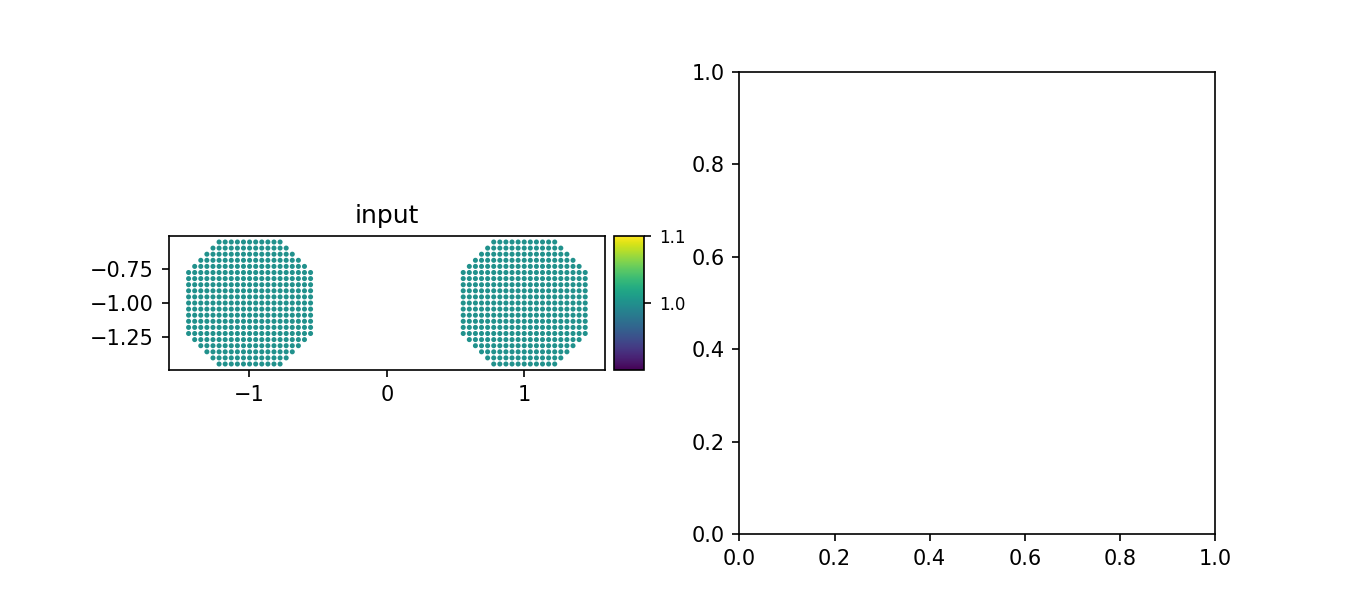

In [215]:

fig, axis = plt.subplots(1, 2, figsize=(9,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('input')
x = fluidPositions[:,0].detach().cpu().numpy()
y = fluidPositions[:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],axis=1).detach().cpu().numpy()
# sc = axis[0,0].tripcolor(x,y,v)
sc = axis[0,0].scatter(x,y,c = v , s = 2)
axis[0,0].axis('equal')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 


In [216]:
debugPrint(training)

training [list] = [('../export/dambreak - 2023-02-09_09-54-16.hdf5', (array([   0,    1,    2, ..., 1437, 1438, 1439]), array([8, 8, 8, ..., 3, 2, 1], dtype=int32)))]


In [217]:
lr = 1e-3

In [218]:
model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])


lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))


optimizer.zero_grad()

train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True).batch_sampler


Number of parameters 4060224


In [219]:
# attrs, inputData, features, gtData = loadFrame(simulationFiles[0],50, np.arange(1))
# # positions, features = prepareInput(inputData)

# positions = inputData['fluidPosition'].to(device)
# features = features.to(device)
# difference = positions
# distance = torch.linalg.norm(difference,axis=1)
# difference[distance > 1e-7] = difference[distance > 1e-7] / distance[distance > 1e-7, None]
# gravity = -1 * difference * (distance)[:,None]
# features = torch.hstack((torch.ones(features.shape[0]).type(torch.float32).to(device).unsqueeze(dim=1), features.to(device), gravity.to(device)))


attributes, inputData, groundTruthData = loadFrame(simFile, 750, np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
prediction = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)

In [220]:
debugPrint(prediction.shape)

prediction.shape [Size] = torch.Size([762, 2])


In [221]:

epoch = 500
maxRollOut = 10
model.train()

lossFn = 'v'
shiftSteps = 2
epochs = 100

In [222]:
# debugPrint(modelOutput)

<IPython.core.display.Javascript object>


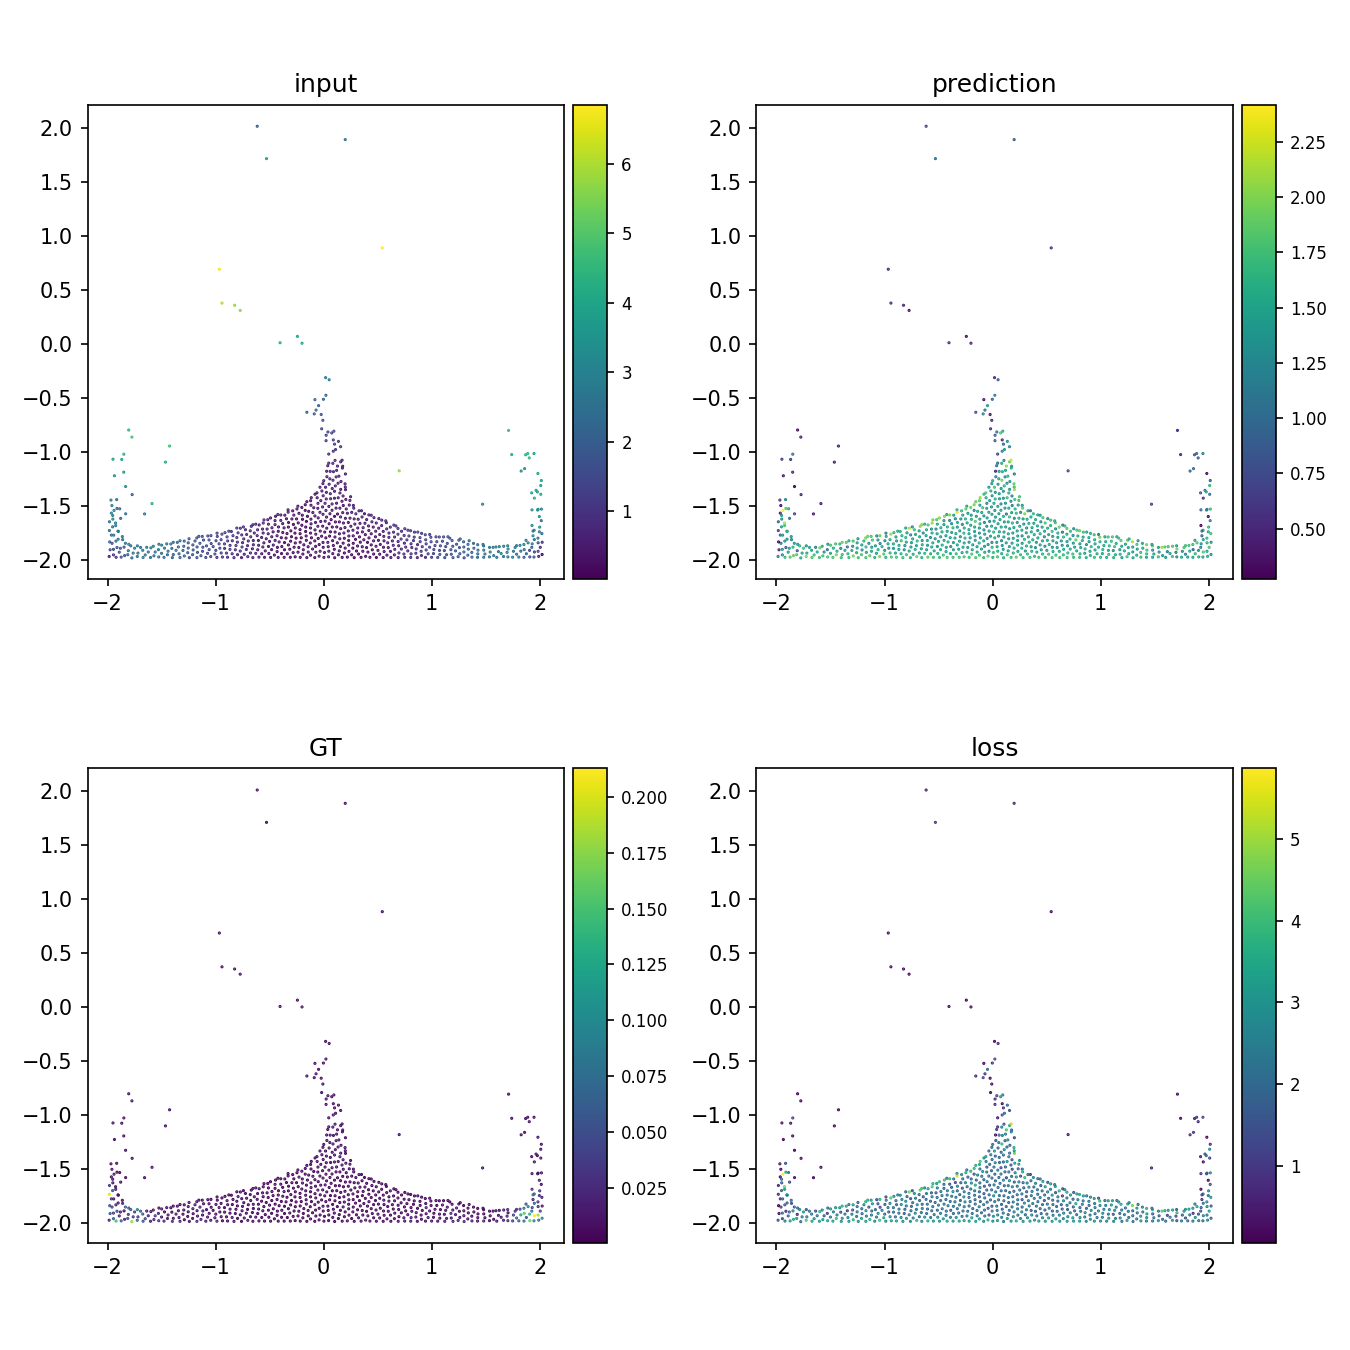

In [223]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]

attributes, inputData, groundTruthData = loadFrame(simFile, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)

positions = inputData['fluidPosition'].to(device)
# difference = positions
# distance = torch.linalg.norm(difference,axis=1)
# difference[distance > 1e-7] = difference[distance > 1e-7] / distance[distance > 1e-7, None]
# gravity = -1 * difference * (distance)[:,None]
# features = torch.hstack((torch.ones(features.shape[0]).type(torch.float32).to(device).unsqueeze(dim=1), features.to(device), gravity.to(device)))

# modelOutput = model(positions, features, positions, attrs['support'], None, None)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device) +  modelOutput 

gt = groundTruthData[0].type(torch.float32).to(device)

loss = torch.linalg.norm(gt - predictedVelocity, dim = 1) ** 2


# print(state['time'])

fig, axis = plt.subplots(2, 2, figsize=(9,9), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('input')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],axis=1).detach().cpu().numpy()
# sc = axis[0,0].tripcolor(x,y,v)
sc = axis[0,0].scatter(x,y,c = v,s=0.25)
axis[0,0].axis('equal')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm((gt - inputData['fluidVelocity'].to(device)) ,axis=1).detach().cpu().numpy()

axis[1,0].set_title('GT')
sc = axis[1,0].scatter(x,y,c = v,s=0.25)
# sc = axis[1,0].tripcolor(x,y,v)
axis[1,0].axis('equal')
ax1_divider = make_axes_locatable(axis[1,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

axis[0,1].set_title('prediction')
v = torch.linalg.norm(modelOutput,axis=1).detach().cpu().numpy()
sc = axis[0,1].scatter(x,y,c = v,s=0.25)
# sc = axis[2,0].tripcolor(x,y,v)
axis[0,1].axis('equal')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 


axis[1,1].set_title('loss')
v = loss.detach().cpu().numpy()
sc = axis[1,1].scatter(x,y,c = v,s=0.25)
# sc = axis[3,0].tripcolor(x,y,v)
axis[1,1].axis('equal')
ax1_divider = make_axes_locatable(axis[1,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


In [224]:
debugPrint(prediction)

prediction [Tensor] = tensor([[ 0.9399,  0.8979],
        [-0.3056,  1.6356],
        [-0.3648,  1.7015],
        ...,
        [ 1.8401,  0.8602],
        [ 1.5436,  0.4207],
        [ 1.2680,  0.5577]], device='cuda:0', grad_fn=<AddBackward0>)


In [225]:
from tqdm.notebook import trange, tqdm

In [226]:


te = tqdm(range(epochs))
t = tqdm(train_dataloader)

overallLosses = []
for e in te:
    t.reset(total=len(train_dataloader))
    for bdata in train_dataloader:
    #     bdata = [len(train_ds)//2]
#         fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
        fileName, frameIndex, maxRollout = train_ds[bdata[0]]
        rollout = np.random.randint(1, min(e//100 + 2, maxRollOut + 1))
        rollout = 1

    #     print(fileName, frameIndex, maxRollout, rollout)

        optimizer.zero_grad()
        attributes, inputData, groundTruthData = loadFrame(simFile, frameIndex, 1 + np.arange(1))
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
#         modelOutput = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)


#         positions = inputData['fluidPosition'].to(device)
#         features = features.to(device)
        
#         difference = positions
#         distance = torch.linalg.norm(difference,axis=1)
#         difference[distance > 1e-7] = difference[distance > 1e-7] / distance[distance > 1e-7, None]
#         gravity = -1 * difference * (distance)[:,None]
#         features = torch.hstack((torch.ones(features.shape[0]).type(torch.float32).to(device).unsqueeze(dim=1), features.to(device), gravity.to(device)))

        losses = []
        realLosses = []
        for i in range(1):
            modelOutput = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)
            predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
            predictedVelocity = inputData['fluidVelocity'].to(device) + modelOutput

            gt = groundTruthData[0].type(torch.float32).to(device)

            loss = torch.linalg.norm(gt - predictedVelocity, dim = 1)
            
            losses.append(torch.mean(loss))

    #     print(len(losses), losses)
        # losses.append(loss)

    #     sumLosses = torch.sum(torch.stack(losses), dim = 0)
        sumLosses = torch.stack(losses)
    #     print(sumLosses)
        sumLosses = torch.sum(sumLosses)
    #     print(sumLosses)

    #     print(sumLosses)
        sumLosses.backward()

        optimizer.step()
        t.set_description('%3d [%5d x %5d] @ %1.5e: %1.5e' %(epoch, bdata[0], rollout, lr, sumLosses))
        t.update()
#         break
    if e % 10 == 0:
        lr = lr * 0.99
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.99 * param_group['lr']


    overallLosses.append(sumLosses)
#     break


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1160 [00:00<?, ?it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


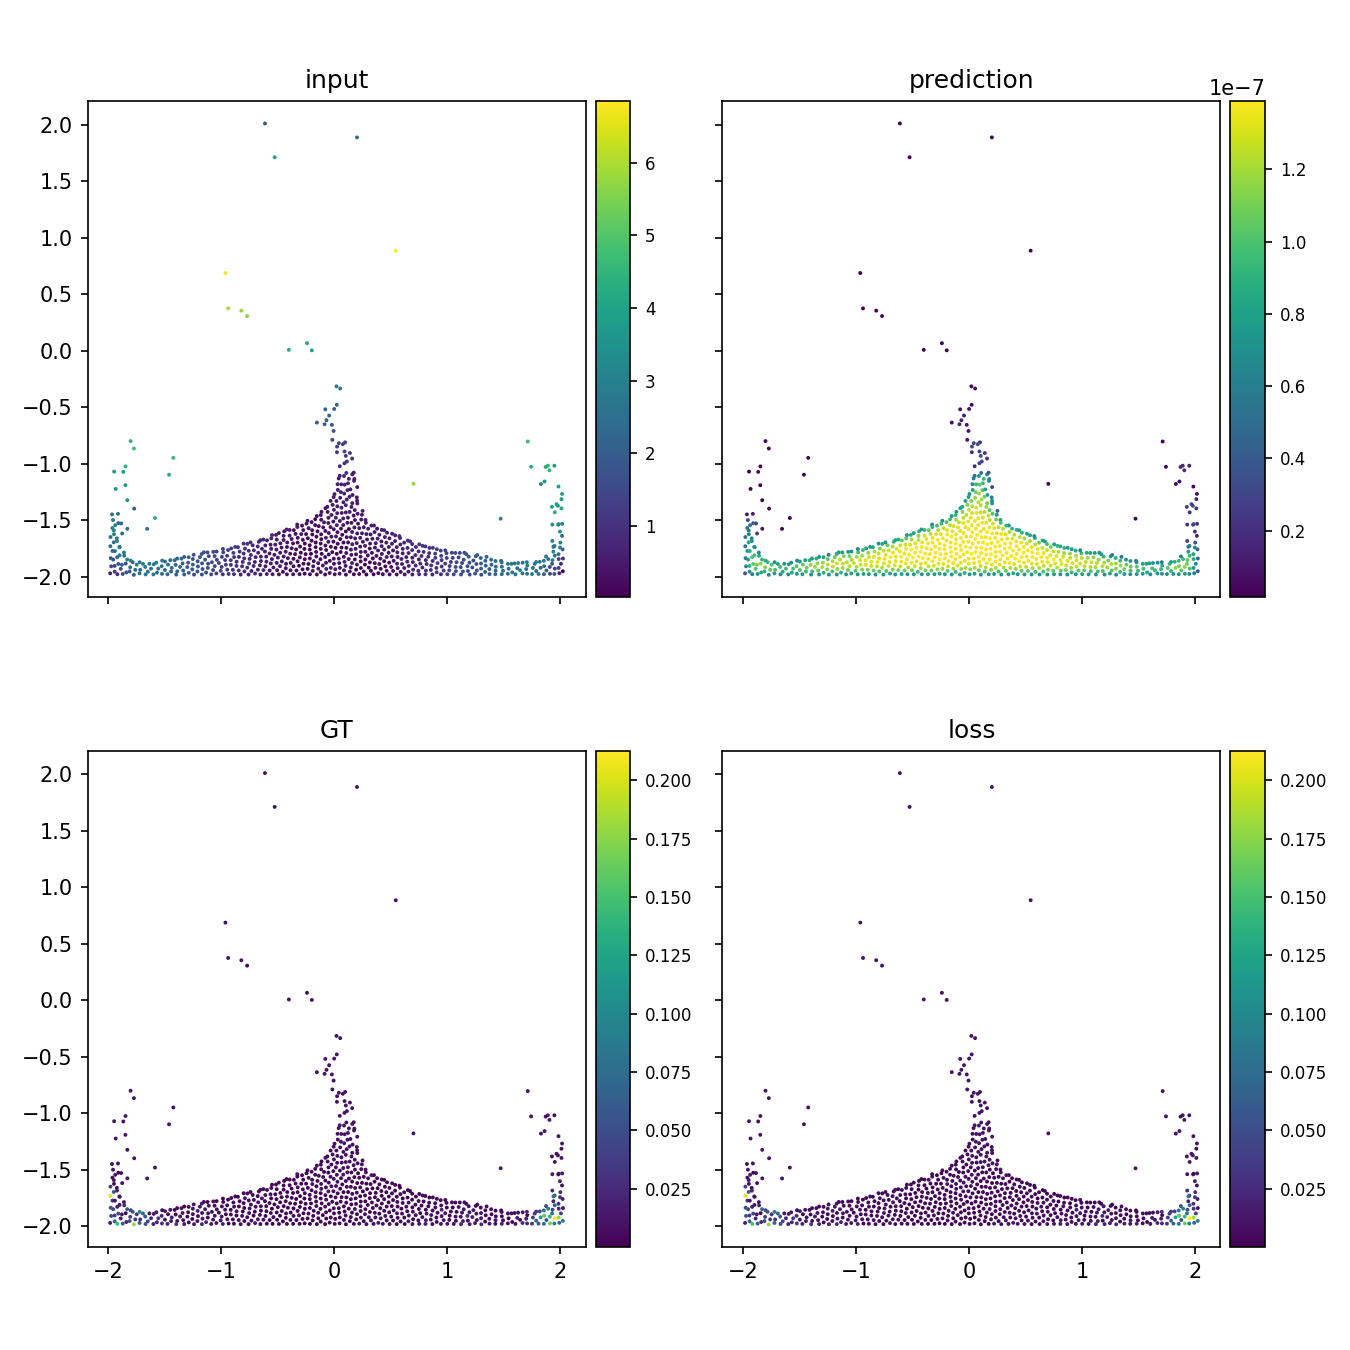

In [227]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# fileName, frameIndex, maxRollout = train_ds[0]

attributes, inputData, groundTruthData = loadFrame(simFile, frameIndex,1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)

positions = inputData['fluidPosition'].to(device)
# features = features.to(device)

# difference = positions
# distance = torch.linalg.norm(difference,axis=1)
# difference[distance > 1e-7] = difference[distance > 1e-7] / distance[distance > 1e-7, None]
# gravity = -1 * difference * (distance)[:,None]
# features = torch.hstack((torch.ones(features.shape[0]).type(torch.float32).to(device).unsqueeze(dim=1), features.to(device), gravity.to(device)))

# modelOutput = model(positions, features, positions, attrs['support'], None, None)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device) +   modelOutput 

gt = groundTruthData[0].type(torch.float32).to(device)

loss = torch.linalg.norm(gt - predictedVelocity, dim = 1)


# print(state['time'])

fig, axis = plt.subplots(2, 2, figsize=(9,9), sharex = True, sharey = True, squeeze = False)

axis[0,0].set_title('input')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],axis=1).detach().cpu().numpy()
sc = axis[0,0].scatter(x,y,c = v,s=0.75)
# sc = axis[0,0].tripcolor(x,y,v)
axis[0,0].axis('equal')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(gt - inputData['fluidVelocity'].to(device),axis=1).detach().cpu().numpy()

axis[1,0].set_title('GT')
sc = axis[1,0].scatter(x,y,c = v,s=0.75)
# sc = axis[1,0].tripcolor(x,y,v)
axis[1,0].axis('equal')
ax1_divider = make_axes_locatable(axis[1,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

axis[0,1].set_title('prediction')
v = torch.linalg.norm(modelOutput,axis=1).detach().cpu().numpy()
sc = axis[0,1].scatter(x,y,c = v,s=0.75)
# sc = axis[2,0].tripcolor(x,y,v)
axis[0,1].axis('equal')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 


axis[1,1].set_title('loss')
v = loss.detach().cpu().numpy()
sc = axis[1,1].scatter(x,y,c = v,s=0.75)
# sc = axis[3,0].tripcolor(x,y,v)
axis[1,1].axis('equal')
ax1_divider = make_axes_locatable(axis[1,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


<IPython.core.display.Javascript object>


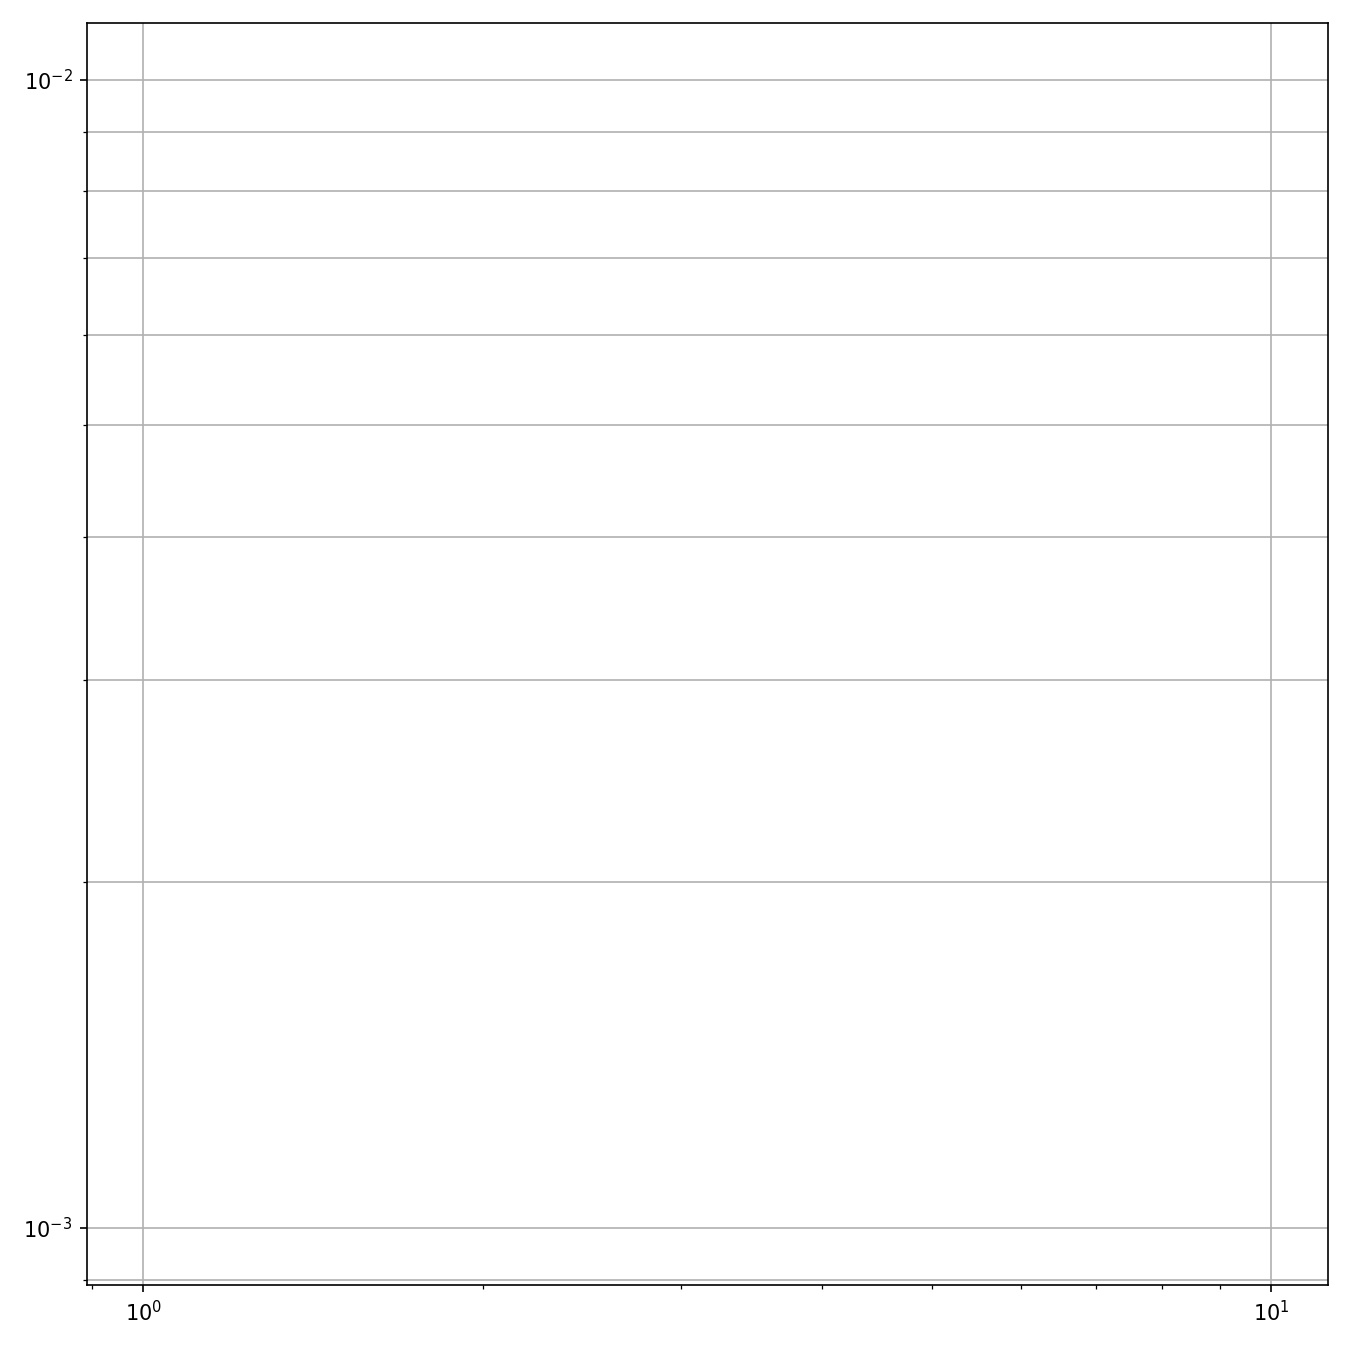

/tmp/ipykernel_2464824/2988743977.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.tight_layout()


In [138]:
fig, axis = plt.subplots(1, 1, figsize=(9,9), sharex = True, sharey = False, squeeze = False)
losses = [loss.detach().cpu().item() for loss in overallLosses]
axis[0,0].loglog(losses)
axis[0,0].grid(True, axis='y', which='both')
axis[0,0].grid(True, axis='x', which='major')
fig.tight_layout()

<IPython.core.display.Javascript object>


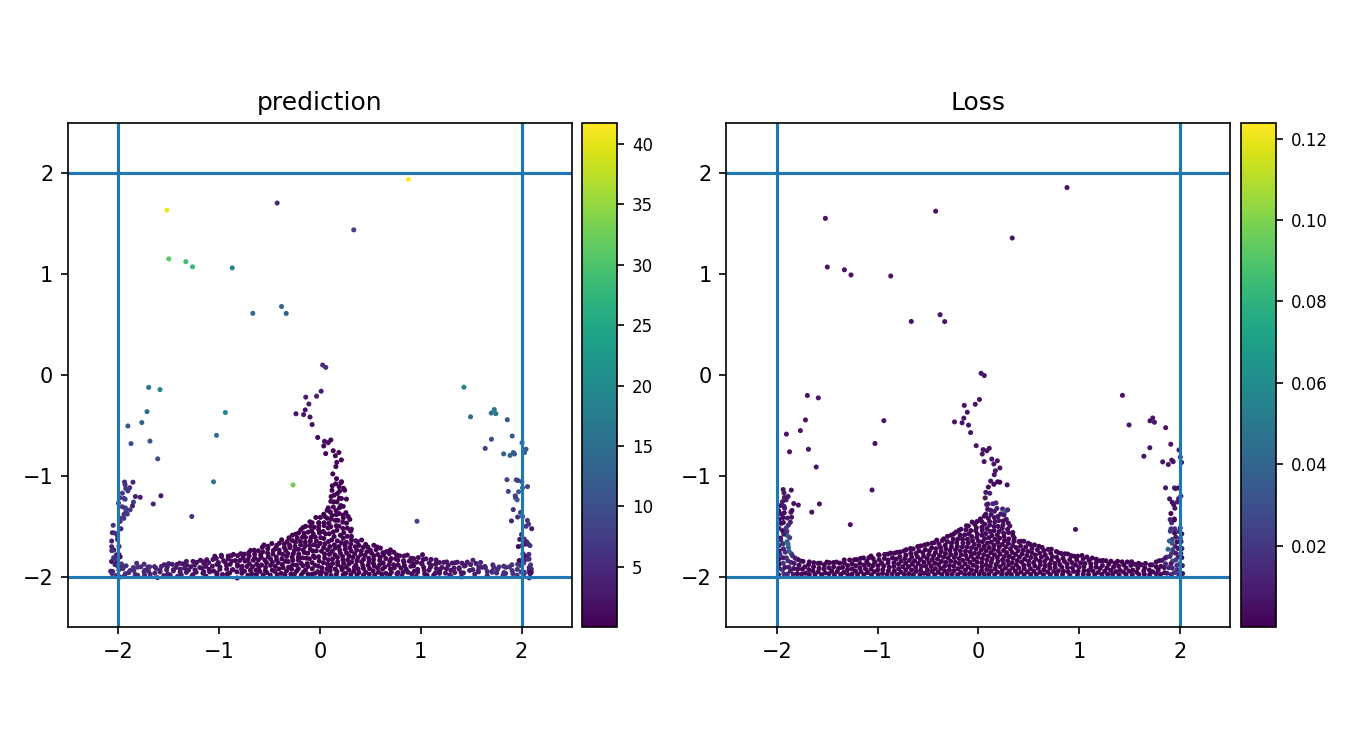

In [139]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(simFile, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)


positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = torch.linalg.norm(gt - predictedVelocity, dim = 1) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 2, figsize=(9,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(modelOutput,axis=1).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

v = torch.linalg.norm(gt - predictedVelocity,axis=1).detach().cpu().numpy()

axis[0,1].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v, s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


In [140]:
debugPrint(fluidFeatures.shape)

fluidFeatures.shape [Size] = torch.Size([762, 5])


In [141]:


# predictedPosition = inputData['fluidPosition'].to(device)
# predictedVelocity = inputData['fluidVelocity'].to(device)

for i in tqdm(range(128)):
#     debugPrint(i)
    fluidFeatures[:,1:3] = predictedVelocity
    
    modelOutput = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], None, None)

    newPosition = predictedPosition + attributes['dt'] * predictedVelocity
    newVelocity = predictedVelocity +  modelOutput

    data = (torch.linalg.norm(modelOutput, dim = 1) ** 2).detach().cpu().numpy()
    data = (torch.linalg.norm(newVelocity, dim = 1) ** 2).detach().cpu().numpy()
    predCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    predSC.set_offsets(newPosition.detach().cpu().numpy())
    predSC.set_array(data)

    attributes, inputData, groundTruthData = loadFrame(fileName,frameIndex + 1)
    data = (torch.linalg.norm(inputData['fluidPosition'].to(device) - newPosition, dim = 1) ** 2).detach().cpu().numpy()
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    GTsc.set_offsets(inputData['fluidPosition'].detach().cpu().numpy())
    GTsc.set_array(data)

    predictedPosition = newPosition
    predictedVelocity = newVelocity
    fig.canvas.draw()
    fig.canvas.flush_events()

    frameIndex = frameIndex + 1
# for i in range(8):
#     modelOutput = model(predictedPosition, predictedVelocity, predictedPosition, attrs['support'], None, None)

#     predictedPosition = inputData['fluidPosition'] + attrs['dt'] * inputData['fluidVelocity']
#     predictedVelocity = inputData['fluidVelocity'].to(device) +  modelOutput

#     gt = gtData[0].type(torch.float32).to(device)
    
    
    

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]

config, state = loadFrame(fileName,frameIndex)
print(state['time'])

fig, axis = plt.subplots(4, 1, figsize=(9,9), sharex = True, sharey = False, squeeze = False)

x = state['fluidPosition'][:,0].detach().cpu().numpy()
y = state['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(state['fluidVelocity'],axis=1).detach().cpu().numpy()
sc = axis[0,0].tripcolor(x,y,v)
axis[0,0].axis('equal')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

prediction = getPrediction(config, state, model)
loss, gt, mask = processPrediction(fileName, prediction, config, state, model, lossFn, update = True)
x = state['fluidPosition'][:,0].detach().cpu().numpy()
y = state['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(state['fluidVelocity'],axis=1).detach().cpu().numpy()

sc = axis[1,0].scatter(x,y,c = v,s=0.25)
axis[1,0].axis('equal')
ax1_divider = make_axes_locatable(axis[1,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

prediction = getPrediction(config, state, model)
loss, gt, mask = processPrediction(fileName, prediction, config, state, model, lossFn, update = True)
x = state['fluidPosition'][:,0].detach().cpu().numpy()
y = state['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(state['fluidVelocity'],axis=1).detach().cpu().numpy()

sc = axis[2,0].scatter(x,y,c = v,s=0.25)
axis[2,0].axis('equal')
ax1_divider = make_axes_locatable(axis[2,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

prediction = getPrediction(config, state, model)
loss, gt, mask = processPrediction(fileName, prediction, config, state, model, lossFn, update = True)
x = state['fluidPosition'][:,0].detach().cpu().numpy()
y = state['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(state['fluidVelocity'],axis=1).detach().cpu().numpy()

sc = axis[3,0].scatter(x,y,c = v,s=0.25)
axis[3,0].axis('equal')
ax1_divider = make_axes_locatable(axis[3,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


In [ ]:
print(prediction)
print(gt)
print(loss)

In [ ]:
# mask = (state['ghostIndices'] == -1).detach().cpu().numpy()
# gammaMask = state['fluidGamma'] == 0
# mask = np.logical_and(mask, gammaMask.detach().cpu().numpy())

x = state['fluidPosition'][:,0].detach().cpu().numpy()[mask.detach().cpu().numpy()]
y = state['fluidPosition'][:,1].detach().cpu().numpy()[mask.detach().cpu().numpy()]
v = torch.linalg.norm(state['fluidVelocity'], dim = 1).detach().cpu().numpy()[mask.detach().cpu().numpy()]
z1 = torch.linalg.norm(gt, dim = 1).detach().cpu().numpy()[mask.detach().cpu().numpy()]
z2 = torch.linalg.norm(prediction, dim = 1).detach().cpu().numpy()[mask.detach().cpu().numpy()]
z3 = torch.linalg.norm(loss, dim = 1).detach().cpu().numpy()[mask.detach().cpu().numpy()]

In [255]:
print(z1.shape, z2.shape, z3.shape)

(22340,) (22340,) (22340,)


<IPython.core.display.Javascript object>


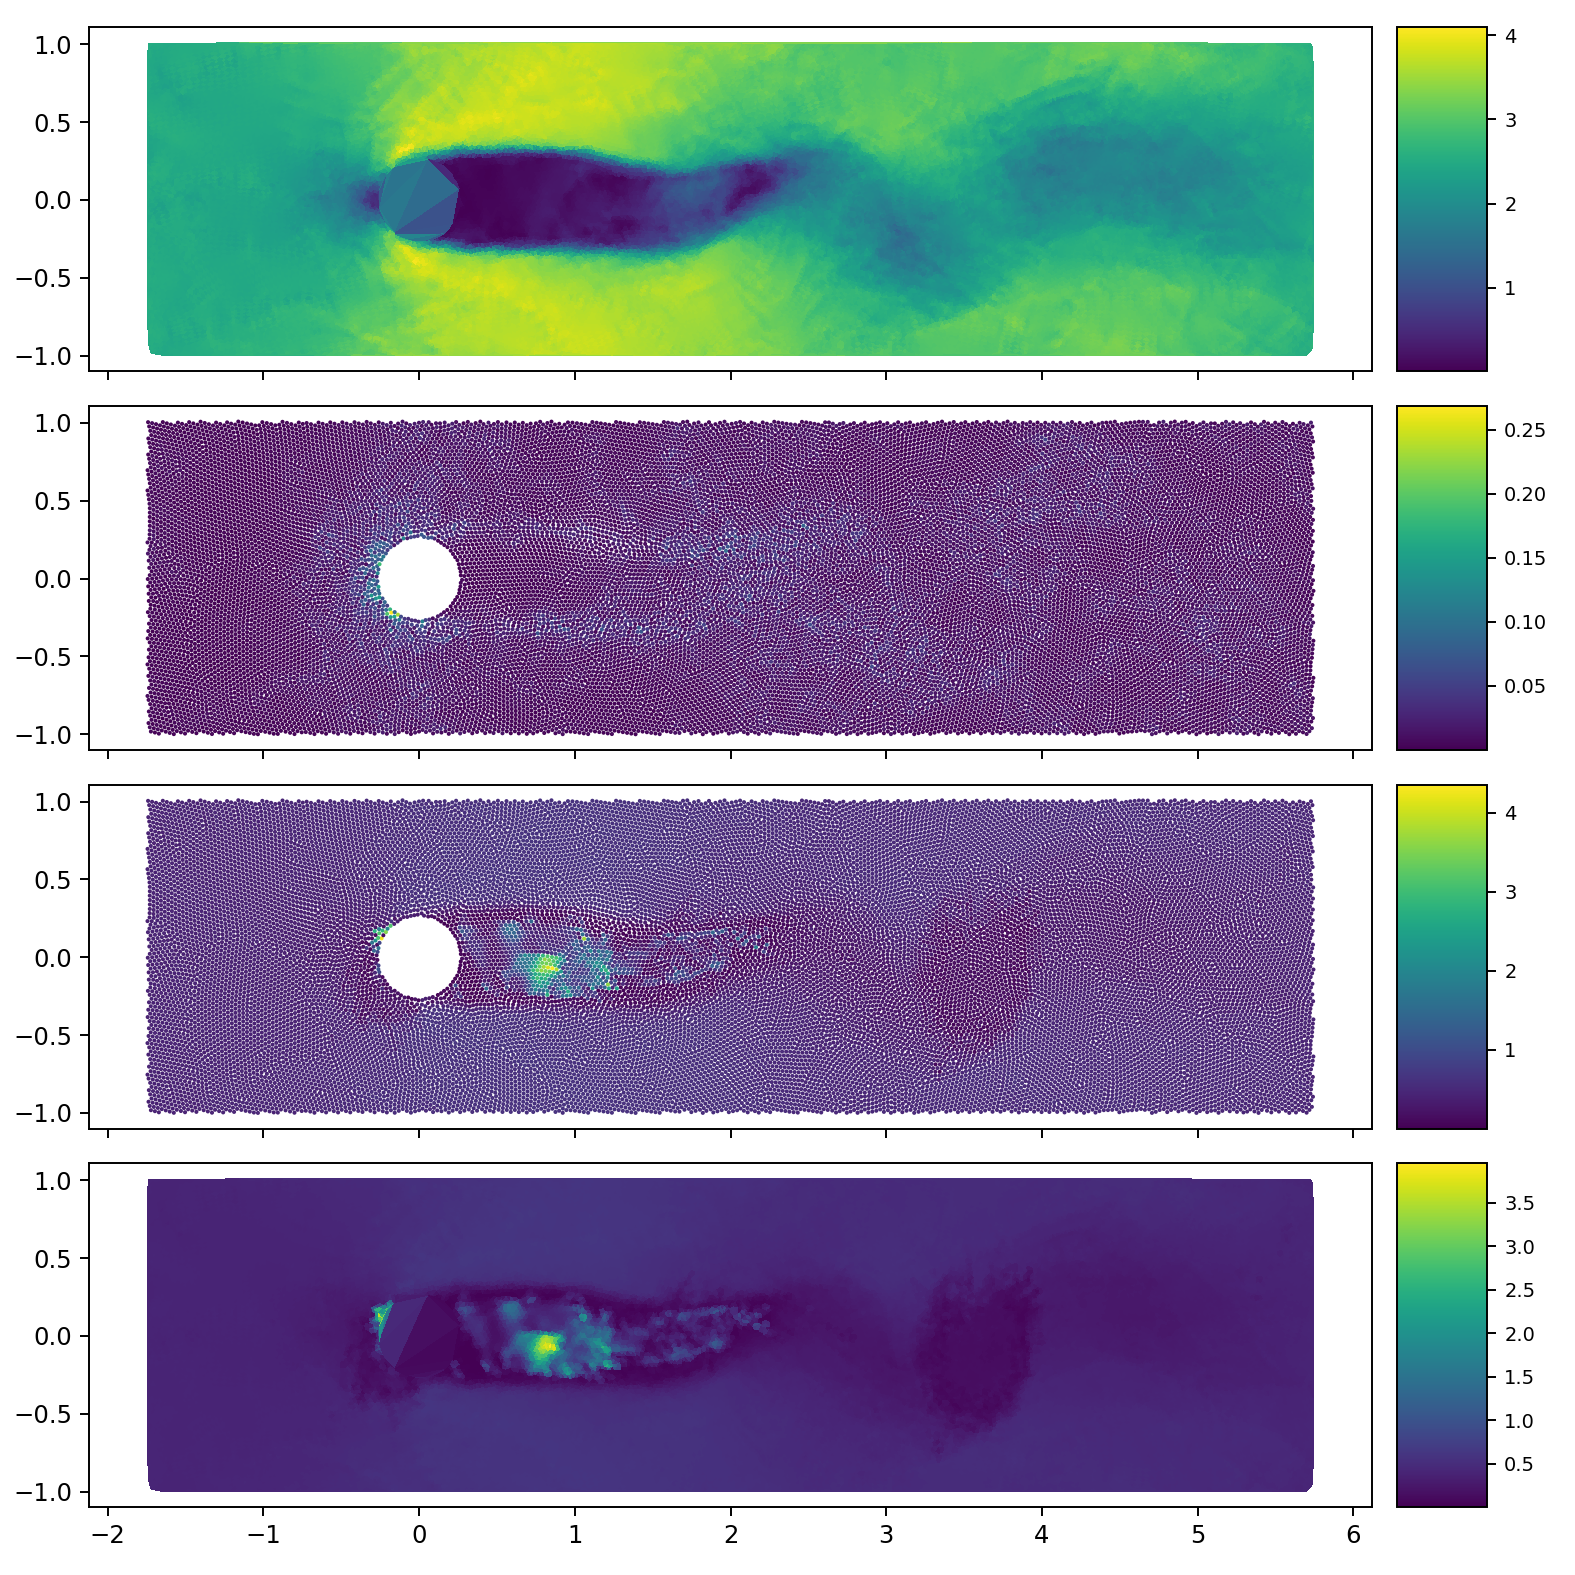

In [256]:
fig, axis = plt.subplots(4, 1, figsize=(9,9), sharex = True, sharey = False, squeeze = False)

sc = axis[0,0].tripcolor(x,y,v)
# sc = axis[0,0].scatter(x,y,c=v,s =0.25)
axis[0,0].axis('equal')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# sc = axis[1,0].tripcolor(x,y,z1)
sc = axis[1,0].scatter(x,y,c=z1,s =0.45)
axis[1,0].axis('equal')
ax1_divider = make_axes_locatable(axis[1,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# sc = axis[2,0].tripcolor(x,y,z2)
sc = axis[2,0].scatter(x,y,c=z2,s =0.45)
axis[2,0].axis('equal')
ax1_divider = make_axes_locatable(axis[2,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

sc = axis[3,0].tripcolor(x,y,z3)
# sc = axis[3,0].scatter(x,y,c=z3,s =0.25)
axis[3,0].axis('equal')
ax1_divider = make_axes_locatable(axis[3,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

In [69]:
config, state = loadFrame(0,500)


losses = []
realLosses = []
for i in tqdm(range(4)):
    prediction = getPrediction(config, state, model)
    prediction, loss = getLoss(prediction, config, state)
    losses.append(loss)
    
    state['fluidPosition'] += state['fluidVelocity'] * config['dt'] + prediction
    state['fluidVelocity'] = state['fluidVelocity'] + prediction / config['dt']

    state['time'] += config['dt']
    state['timestep'] += 1

    realLoss = getRealLoss(0, state['timestep'], config, state, 'fluidPosition')
    # realLoss = getRealLoss(0, state['timestep'] - 1, config, state, 'positionAfterStep')

    realLosses.append(realLoss)
    
    state['fluidPosition'] = state['fluidPosition'].detach()

    advanceSimulation(prediction, config, state, shiftSteps = 0)

# losses.append(loss)

sumLosses = torch.sum(torch.stack(realLosses), dim = 0)
sumLosses = torch.mean(sumLosses)

print(sumLosses)
sumLosses.backward()

# print(realLoss)

# torch.mean(realLoss).backward()

TypeError: expected str, bytes or os.PathLike object, not int

<IPython.core.display.Javascript object>


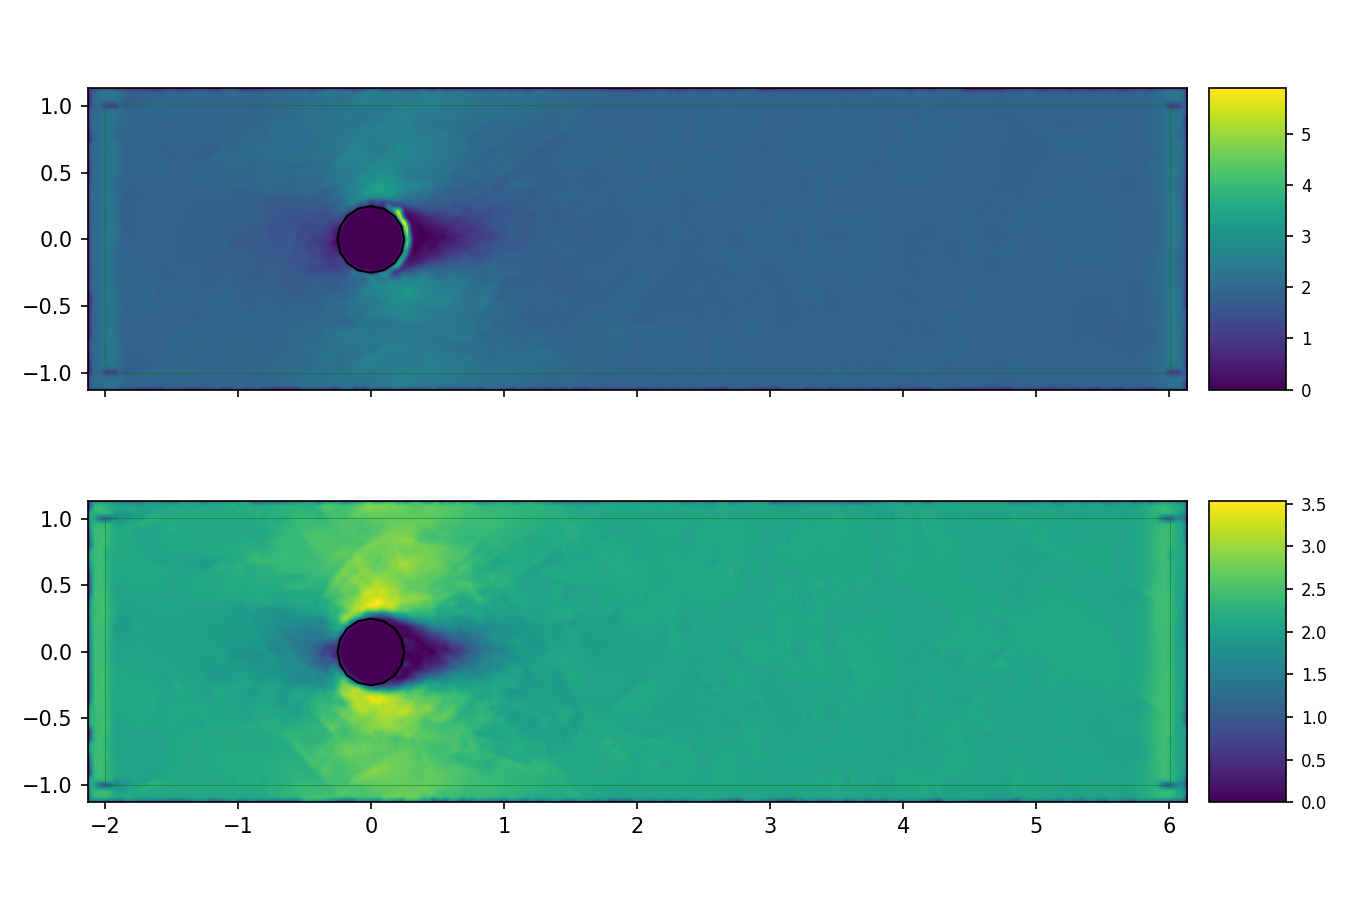

In [94]:
fig, axis = plt.subplots(2,1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

nx = 512
ny = 256


axis[0,0].axis('equal')
plotDomain(axis[0,0], config)
plotBoundary(axis[0,0], config)
axis[1,0].axis('equal')
plotDomain(axis[1,0], config)
plotBoundary(axis[1,0], config)

xx,yy,uvPred = getUVs(state['fluidVelocity'], config, state, nx, ny)
dataPred = np.linalg.norm(uvPred, axis=2)
dataPred = dataPred[::-1,:]
imPred = axis[0,0].imshow(dataPred, extent =(config['domain']['min'][0], config['domain']['max'][0], config['domain']['min'][1], config['domain']['max'][1]))

configGT, stateGT = loadFrame(0, state['timestep'])
xx,yy,uvGT = getUVs(stateGT['fluidVelocity'], configGT, stateGT, nx, ny)
dataGT = np.linalg.norm(uvGT, axis=2)
dataGT = dataGT[::-1,:]
imGT = axis[1,0].imshow(dataGT, extent =(config['domain']['min'][0], config['domain']['max'][0], config['domain']['min'][1], config['domain']['max'][1]))


ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbarPred = fig.colorbar(imPred, cax=cax1,orientation='vertical')
cbarPred.ax.tick_params(labelsize=8) 
ax1_divider = make_axes_locatable(axis[1,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbarGT = fig.colorbar(imGT, cax=cax1,orientation='vertical')
cbarGT.ax.tick_params(labelsize=8) 


fig.tight_layout()

In [95]:
from tqdm.notebook import tqdm, trange

In [96]:
realLosses = []

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True, with_flops=True) as prof:    
for i in tqdm(range(16)):
    with record_function('prediction'):
        prediction = getPrediction(config, state, model)
    with record_function('advancing simulation'):
        advanceSimulation(prediction, config, state)
    with record_function('loss computation'):
        realLosses.append(getRealLoss(0,state['timestep'],config,state))

    with record_function('plotting'):
        xx,yy,uvPred = getUVs(state['fluidVelocity'], config, state, nx, ny)
        dataPred = np.linalg.norm(uvPred, axis=2)
        dataPred = dataPred[::-1,:]

        configGT, stateGT = loadFrame(0, state['timestep'])
        xx,yy,uvGT = getUVs(stateGT['fluidVelocity'], configGT, stateGT, nx, ny)
        dataGT = np.linalg.norm(uvGT, axis=2)
        dataGT = dataGT[::-1,:]

        imPred.set_data(dataPred)
        cbarPred.mappable.set_clim(vmin=np.min(dataPred), vmax=np.max(dataPred))

        imGT.set_data(dataGT)
        cbarGT.mappable.set_clim(vmin=np.min(dataGT), vmax=np.max(dataGT))

        fig.canvas.draw()
        fig.canvas.flush_events()
        #                     im.set_data(data)

  0%|          | 0/16 [00:00<?, ?it/s]

In [47]:

# import sys
# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('profile.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     print(prof.key_averages().table(sort_by='self_cpu_time_total'))
#     sys.stdout = original_stdout # Reset the standard output to its original value


In [48]:
# prof.export_chrome_trace("trace.json")


<IPython.core.display.Javascript object>


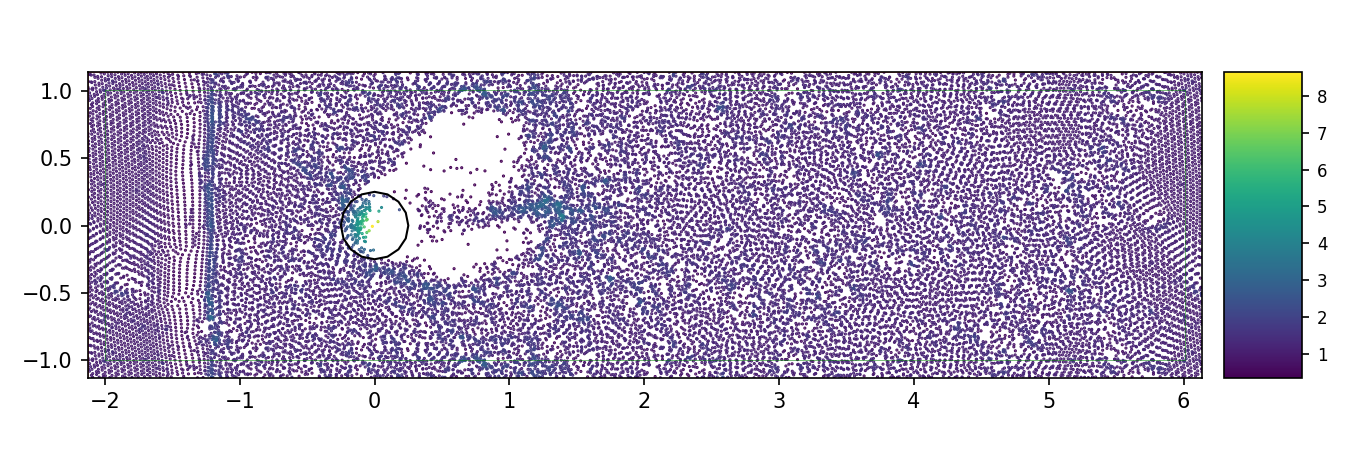

In [71]:
fig, axis = plt.subplots(1,1, figsize=(9,3), sharex = True, sharey = False, squeeze = False)

realParticles = state['ghostIndices'] == -1

uids = state['UID'][realParticles]

# loss = torch.linalg.norm(state['positionAfterStep'] - ballisticPosition, axis=1) / config['support']

# loss = torch.linalg.norm((state['positionAfterStep'] - state['fluidPosition'])/ config['dt'] / config['support'], axis = 1)
# loss = torch.linalg.norm(state['fluidVelocity'],axis = 1) / config['support']

# print(torch.mean(loss))

sc = axis[0,0].scatter(state['fluidPosition'][:,0].detach().cpu().numpy(), state['fluidPosition'][:,1].detach().cpu().numpy(),\
                 s = 0.25, c = state['fluidDensity'].detach().cpu().numpy())

axis[0,0].axis('equal')
plotDomain(axis[0,0], config)
plotBoundary(axis[0,0], config)

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 


fig.tight_layout()

In [58]:
print(torch.mean(loss).item())
print(np.array([torch.mean(m).detach().cpu().item() for m in realLosses]))

6.436992407543585e-05
[0.00303822 0.00645094 0.01037171 0.0148882  0.02004476 0.02582364
 0.03225577 0.03934458 0.04708486 0.05546509 0.06446871 0.07407328
 0.08427878 0.09506921 0.10643066 0.1183368 ]


<IPython.core.display.Javascript object>


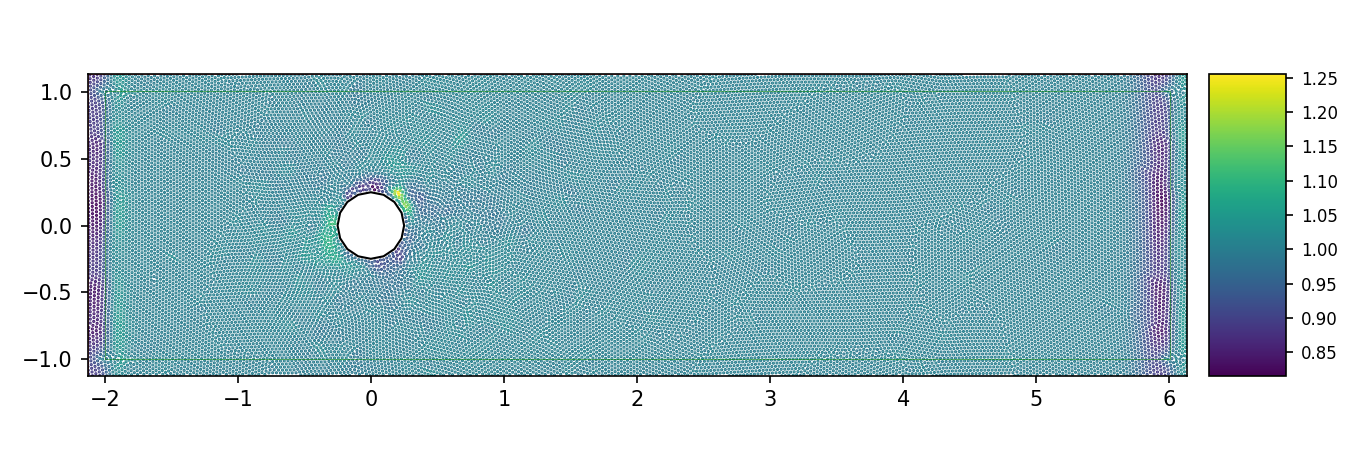

In [49]:
fig, axis = plt.subplots(1,1, figsize=(9,3), sharex = True, sharey = False, squeeze = False)

realParticles = state['ghostIndices'] == -1

uids = state['UID'][realParticles]

# loss = torch.linalg.norm(state['positionAfterStep'] - ballisticPosition, axis=1) / config['support']

# loss = torch.linalg.norm((state['positionAfterStep'] - state['fluidPosition'])/ config['dt'] / config['support'], axis = 1)
# loss = torch.linalg.norm(state['fluidVelocity'],axis = 1) / config['support']

# print(torch.mean(loss))

sc = axis[0,0].scatter(state['fluidPosition'][:,0].detach().cpu().numpy(), state['fluidPosition'][:,1].detach().cpu().numpy(),\
                 s = 0.25, c = state['fluidDensity'].detach().cpu().numpy())

axis[0,0].axis('equal')
plotDomain(axis[0,0], config)
plotBoundary(axis[0,0], config)

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 


fig.tight_layout()

In [50]:
print(torch.mean(loss).item())
print(np.array([torch.mean(m).detach().cpu().item() for m in realLosses]))

6.436992407543585e-05
[0.00095525 0.0027932  0.00548833 0.00902139 0.01336381 0.01846601
 0.02430995 0.03088504 0.03816896 0.04612254 0.05473365 0.06396264
 0.0738081  0.08425455 0.09528197 0.10685411]


In [236]:
print(torch.mean(loss).item())
print(np.array([torch.mean(m).detach().cpu().item() for m in realLosses]))

3.0841303669149056e-05
[0.00041746 0.00117945 0.00228684 0.00374579 0.00554045 0.00765428
 0.01013778 0.01299513 0.0162036  0.0197692  0.02365724 0.02788601
 0.03246731 0.03739544 0.04266274 0.04829258]


In [90]:

enforcePeriodicBC(config, state)
state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
    neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

state['boundaryNeighbors'], state['boundaryDistances'], state['boundaryGradients'], \
    state['boundaryIntegrals'], state['boundaryIntegralGradients'], \
    state['boundaryFluidNeighbors'], state['boundaryFluidPositions'] = boundaryNeighborSearch(config, state)

state['fluidDensity'] = sphDensity(config, state)  
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True, with_flops=False) as prof:    
    for i in tqdm(range(4)):
        solveShifting(config, state)
        

import sys
original_stdout = sys.stdout # Save a reference to the original standard output

with open('profile.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prof.key_averages().table(sort_by='self_cpu_time_total'))
    sys.stdout = original_stdout # Reset the standard output to its original value
prof.export_chrome_trace("trace.json")


  0%|          | 0/4 [00:00<?, ?it/s]

In [330]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True, with_flops=True) as prof:    
    for i in range(4):
        state['boundaryNeighbors'], state['boundaryDistances'], state['boundaryGradients'], \
            state['boundaryIntegrals'], state['boundaryIntegralGradients'], \
            state['boundaryFluidNeighbors'], state['boundaryFluidPositions'] = boundaryNeighborSearch(config, state)


In [329]:

import sys
original_stdout = sys.stdout # Save a reference to the original standard output

with open('profile.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prof.key_averages().table(sort_by='self_cpu_time_total'))
    sys.stdout = original_stdout # Reset the standard output to its original value
prof.export_chrome_trace("trace.json")
